In [63]:
import pickle
import os
import sys
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
def parse_papers_groupby_newline(file_path):
    # Read the file and split by double newlines (delimiter between papers)
    with open(file_path, 'r',encoding='utf-8') as file:
        paper_blocks = file.read().strip().split("\n\n")
    
    # Initialize list to store paper data
    papers = []
    
    # Process each paper block
    for block in paper_blocks:
        current_paper = {
            "title": None,
            "authors": None,
            "year": None,
            "venue": None,
            "index": None,
            "citations": [],
            "abstract": None,
        }
        # Process lines within the block
        for line in block.split("\n"):
            line = line.strip()
            if line.startswith('#*'):  # Title
                current_paper["title"] = line[2:]
            elif line.startswith('#@'):  # Authors
                current_paper["authors"] = line[2:]
            elif line.startswith('#t'):  # Year
                current_paper["year"] = line[2:]
            elif line.startswith('#c'):  # Venue
                current_paper["venue"] = line[2:]
            elif line.startswith('#index'):  # Index
                current_paper["index"] = line[6:]
            elif line.startswith('#%'):  # Citations
                current_paper["citations"].append(line[2:])
            elif line.startswith('#!'):  # Abstract
                current_paper["abstract"] = line[2:]
            
        papers.append(current_paper)
    
    # Convert to DataFrame
    df = pd.DataFrame(papers)
    df["citations"] = df["citations"].apply(lambda x: ";".join(x) if x else None)
    return df

# Usage
file_path = "Data/papers.txt" 
df = parse_papers_groupby_newline(file_path)

In [65]:
df.index

RangeIndex(start=0, stop=629814, step=1)

In [66]:
import pandas as pd

def analyze_dataframe(df):
    # Create a summary DataFrame
    summary = {
        "Column": [],
        "Data Type": [],
        "Min Value": [],
        "Max Value": [],
        "Missing Values": []
    }
    
    for column in df.columns:
        summary["Column"].append(column)
        summary["Data Type"].append(df[column].dtype)
        
        if pd.api.types.is_numeric_dtype(df[column]):
            # If column is numeric, calculate min and max
            summary["Min Value"].append(df[column].min())
            summary["Max Value"].append(df[column].max())
        elif pd.api.types.is_datetime64_any_dtype(df[column]):
            # If column is datetime, calculate min and max
            summary["Min Value"].append(df[column].min())
            summary["Max Value"].append(df[column].max())
        else:
            # For non-numeric and non-datetime columns, set min and max as N/A
            summary["Min Value"].append("N/A")
            summary["Max Value"].append("N/A")
        
        # Count missing values
        summary["Missing Values"].append(df[column].isnull().sum())
    
    # Convert summary to a DataFrame for better readability
    summary_df = pd.DataFrame(summary)
    return summary_df

# Usage
analysis = analyze_dataframe(df)
print(analysis)


      Column Data Type Min Value Max Value  Missing Values
0      title    object       N/A       N/A               0
1    authors    object       N/A       N/A               0
2       year    object       N/A       N/A               0
3      venue    object       N/A       N/A               0
4      index    object       N/A       N/A               0
5  citations    object       N/A       N/A          504442
6   abstract    object       N/A       N/A          348734


In [67]:
df.shape

(629814, 7)

In [68]:
# Drop only the 'abstract' column
df_cleaned = df.drop(columns=['abstract'])
# Check the updated DataFrame
print(df_cleaned.shape)


(629814, 6)


In [69]:
print(df_cleaned.iloc[50])


title        Exploring Macintosh Concepts in Visually Orien...
authors                                          Ken Abernethy
year                                                      2000
venue                                                         
index                                                       50
citations                                                 None
Name: 50, dtype: object


In [70]:
# Mostra le prime righe del DataFrame
print("First few rows of the dataset:")
print(df_cleaned.head())

# Mostra il numero totale di righe e colonne
print("\nShape of the dataset (rows, columns):")
print(df_cleaned.shape)

# Mostra i nomi delle colonne
print("\nColumn names in the dataset:")
print(df_cleaned.columns)

# Mostra il tipo di dato per ciascuna colonna
print("\nData types of each column:")
print(df_cleaned.dtypes)

# Controlla se ci sono valori nulli
print("\nMissing values in each column:")
print(df_cleaned.isnull().sum())

# Descrizione statistica del dataset
print("\nStatistical description of numerical columns:")
print(df_cleaned.describe())

# Campione casuale per avere un'idea dei dati
print("\nRandom sample from the dataset:")
print(df_cleaned.sample(5))


First few rows of the dataset:
                                               title  \
0  Automated Deduction in Geometry: 5th Internati...   
1  A+ Certification Core Hardware (Text & Lab Man...   
2  Performance engineering in industry: current p...   
3      Dude, You Can Do It! How to Build a Sweeet PC   
4  What Every Programmer Needs to Know about Secu...   

                           authors  year  \
0          Hoon Hong,Dongming Wang  2006   
1                Charles J. Brooks  2003   
2  Ahmed E. Hassan,Parminder Flora  2007   
3   Darrel Creacy,Carlito Vicencio  2005   
4       Neil Daswani,Anita Kesavan  2006   

                                               venue index citations  
0                                                        0      None  
1                                                        1      None  
2  Proceedings of the 6th international workshop ...     2      None  
3                                                        3      None  
4           

In [71]:
# Analizza le citazioni per comprendere meglio le loro diverse forme

# Controlla quante righe hanno citazioni vuote
print("\nNumber of rows where citations are None or empty:")
print(df_cleaned['citations'].isnull().sum())

# Campione di righe con citazioni non vuote
print("\nSample rows with non-empty citations:")
print(df_cleaned[df_cleaned['citations'].notnull()].sample(5))

# Dividi le citazioni multiple e conta il numero medio di citazioni per riga
def count_citations(citation_string):
    if pd.isnull(citation_string):  # Se è None o NaN
        return 0
    else:
        return len(citation_string.split(';'))

df_cleaned['citation_count'] = df_cleaned['citations'].apply(count_citations)

print("\nStatistics on the number of citations per row:")
print(df_cleaned['citation_count'].describe())

# Campione di righe con più di una citazione
print("\nSample rows with multiple citations:")
print(df_cleaned[df_cleaned['citation_count'] > 1].sample(5))



Number of rows where citations are None or empty:
504442

Sample rows with non-empty citations:
                                                    title  \
443571            Latin Squares for Parallel Array Access   
93224   Predicting Nearly As Well As the Best Pruning ...   
140793  A Semantics-based Visual Framework for Plannin...   
244463  Calibration as parameter estimation in sensor ...   
25020   Accurate and Scalable Surface Representation a...   

                                                  authors  year  \
443571                              K. Kim,V. K. Prasanna  1993   
93224                David P. Helmbold,Robert E. Schapire  1997   
140793                  Carlo Biagioli,Enrico Francesconi  2005   
244463                      Kamin Whitehouse,David Culler  2002   
25020   Gang Zeng,Sylvain Paris Long Quan,Francois Sil...  2007   

                                                    venue   index  \
443571  IEEE Transactions on Parallel and Distributed ...  44357

In [72]:
# Analizza la colonna 'venue'

# Controlla il numero di valori unici
print("\nNumber of unique values in 'venue':")
print(df_cleaned['venue'].nunique())

# Mostra i valori più frequenti
print("\nTop 10 most frequent venues:")
print(df_cleaned['venue'].value_counts().head(10))

# Mostra il numero di righe con 'venue' vuoto o None
print("\nNumber of rows where 'venue' is empty or None:")
print(df_cleaned['venue'].isnull().sum())

# Campione di righe con valori non vuoti in 'venue'
print("\nSample rows with non-empty 'venue':")
print(df_cleaned[df_cleaned['venue'].notnull()].sample(5))

# Descrizione statistica
print("\nStatistical description of the 'venue' column:")
print(df_cleaned['venue'].describe())



Number of unique values in 'venue':
12610

Top 10 most frequent venues:
venue
                                                    98594
Communications of the ACM                            7107
Computer                                             5057
IEEE Transactions on Computers                       3451
Discrete Mathematics                                 3388
Theoretical Computer Science                         3271
Journal of Computational and Applied Mathematics     3091
Microelectronic Engineering                          2903
Journal of Computational Physics                     2897
Fuzzy Sets and Systems                               2794
Name: count, dtype: int64

Number of rows where 'venue' is empty or None:
0

Sample rows with non-empty 'venue':
                                                    title  \
573308  Book review: Neural Networks and Fuzzy Systems...   
261667  On Classification Schemes for Computer Systems...   
406790                                       

In [73]:
from sklearn.preprocessing import LabelEncoder

# Crea un oggetto LabelEncoder
label_encoder = LabelEncoder()

# Applica il Label Encoding alla colonna 'venue'
df_cleaned['venue_encoded'] = label_encoder.fit_transform(df_cleaned['venue'])

# Controlla le prime righe per verificare il risultato
print("First few rows with 'venue' and 'venue_encoded':")
print(df_cleaned[['venue', 'venue_encoded']].head())

# Verifica i valori unici originali e codificati
print("\nNumber of unique values in 'venue':", df_cleaned['venue'].nunique())
print("Number of unique values in 'venue_encoded':", df_cleaned['venue_encoded'].nunique())

# Mappa inversa per debugging
venue_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nSample of the venue mapping (original -> encoded):")
print(dict(list(venue_mapping.items())[:10]))

# Controlla una statistica per assicurarti che tutto sia corretto
print("\nStatistics for 'venue_encoded':")
print(df_cleaned['venue_encoded'].describe())


First few rows with 'venue' and 'venue_encoded':
                                               venue  venue_encoded
0                                                                 0
1                                                                 0
2  Proceedings of the 6th international workshop ...           8193
3                                                                 0
4                                                                 0

Number of unique values in 'venue': 12610
Number of unique values in 'venue_encoded': 12610

Sample of the venue mapping (original -> encoded):
{'': 0, '(1987)': 1, '(1992&ndash;1993)': 2, '(1993&ndash;1994)': 3, '(1994 Supplement)': 4, '(Fall 1991)': 5, '(Fall/Winter 1991)': 6, '(February 1987)': 7, '(February 1991)': 8, '(Jan./Feb. 1991)': 9}

Statistics for 'venue_encoded':
count    629814.000000
mean       4703.601455
std        3950.644911
min           0.000000
25%        1003.000000
50%        4178.000000
75%        8037.000000
m

In [74]:
# Step 1: Filtrare gli articoli con il maggior numero di citazioni
# Assumiamo che 'citation_count' sia già calcolato e rappresenti il numero di citazioni di ogni articolo

# Filtra i 10,000 articoli più citati
most_cited_articles = df_cleaned.nlargest(10000, 'citation_count')

# Debug: Mostra il numero di articoli filtrati e alcune statistiche
print("Number of most cited articles selected:", most_cited_articles.shape[0])
print("\nTop 5 articles by citation count:")
print(most_cited_articles[['index', 'title', 'citation_count', 'year']].head())
print("\nStatistics of citation count for the selected articles:")
print(most_cited_articles['citation_count'].describe())

# Debug: Controlla che non ci siano articoli con citazioni mancanti o anomale
print("\nAre there any articles with missing citation_count?")
print(most_cited_articles['citation_count'].isnull().sum())


Number of most cited articles selected: 10000

Top 5 articles by citation count:
         index                                              title  \
216749  216749    Query evaluation techniques for large databases   
513215  513215              A compendium of key search references   
109762  109762                  A brief survey of program slicing   
304647  304647  Hundreds of impossibility results for distribu...   
517478  517478  An annotated bibliography of computer supporte...   

        citation_count  year  
216749             195  1993  
513215             182  1990  
109762             178  2005  
304647             155  2003  
517478             148  1991  

Statistics of citation count for the selected articles:
count    10000.000000
mean        17.290500
std          8.933034
min         12.000000
25%         13.000000
50%         15.000000
75%         18.000000
max        195.000000
Name: citation_count, dtype: float64

Are there any articles with missing citation_co

In [75]:
# Step 2: Generare coppie di articoli con almeno un anno di differenza e ordine temporale corretto
def generate_article_pairs_corrected(articles_df):
    pairs = []
    for article_a, article_b in combinations(articles_df.itertuples(), 2):
        # Controlla che ci sia almeno un anno di differenza
        year_a = int(article_a.year)
        year_b = int(article_b.year)
        if year_a > year_b:  # Garantisce che l'ordine temporale sia rispettato
            pairs.append((article_a.index, article_b.index, year_a, year_b))
        elif year_b > year_a:  # Coppia inversa valida
            pairs.append((article_b.index, article_a.index, year_b, year_a))
        # Limita il numero di coppie a 10,000 per debug veloce
        if len(pairs) >= 10000:
            break
    return pairs

# Genera le coppie di articoli con il filtro corretto
article_pairs_corrected = generate_article_pairs_corrected(most_cited_articles)

# Debug: Mostra un esempio delle coppie generate
print(f"Number of pairs generated (corrected): {len(article_pairs_corrected)}")
print("\nSample of generated pairs (article_index_A, article_index_B, year_A, year_B):")
print(article_pairs_corrected[:5])



Number of pairs generated (corrected): 10000

Sample of generated pairs (article_index_A, article_index_B, year_A, year_B):
[('216749', '513215', 1993, 1990), ('109762', '216749', 2005, 1993), ('304647', '216749', 2003, 1993), ('216749', '517478', 1993, 1991), ('625521', '216749', 2001, 1993)]


In [76]:
# Verifica che tutte le coppie rispettino la logica temporale
def validate_article_pairs(pairs):
    invalid_pairs = []
    for pair in pairs:
        year_a = pair[2]
        year_b = pair[3]
        # Controlla la condizione di almeno un anno di differenza e ordine corretto
        if not (year_a > year_b or year_b > year_a):
            invalid_pairs.append(pair)
    
    # Debug: Stampa il risultato della validazione
    print("\nValidation Results:")
    print(f"Total pairs checked: {len(pairs)}")
    print(f"Invalid pairs found: {len(invalid_pairs)}")
    
    if invalid_pairs:
        print("\nSample of invalid pairs:")
        print(invalid_pairs[:5])
    else:
        print("All pairs are valid!")

# Esegui la validazione sulle coppie generate
validate_article_pairs(article_pairs_corrected)



Validation Results:
Total pairs checked: 10000
Invalid pairs found: 0
All pairs are valid!


In [77]:
# Step: Arricchire le coppie con tutte le feature degli articoli, inclusa la lista delle citazioni
def enrich_article_pairs(pairs, articles_df):
    enriched_pairs = []
    for pair in pairs:
        article_a = articles_df[articles_df['index'] == pair[0]].iloc[0]
        article_b = articles_df[articles_df['index'] == pair[1]].iloc[0]
        enriched_pairs.append({
            'article_a': {
                'index': article_a['index'],
                'title': article_a['title'],
                'authors': article_a['authors'],
                'year': article_a['year'],
                'venue': article_a['venue'],
                'citation_count': article_a['citation_count'],
                'citations': article_a['citations']  # Aggiungiamo le citazioni
            },
            'article_b': {
                'index': article_b['index'],
                'title': article_b['title'],
                'authors': article_b['authors'],
                'year': article_b['year'],
                'venue': article_b['venue'],
                'citation_count': article_b['citation_count'],
                'citations': article_b['citations']  # Aggiungiamo le citazioni
            }
        })
    return enriched_pairs

# Rigenera le coppie arricchite con le citazioni
enriched_pairs = enrich_article_pairs(article_pairs_corrected, most_cited_articles)




Graph Information:
Numero di nodi: 9576
Numero di archi: 10000
Numero di componenti fortemente connessi: 9576


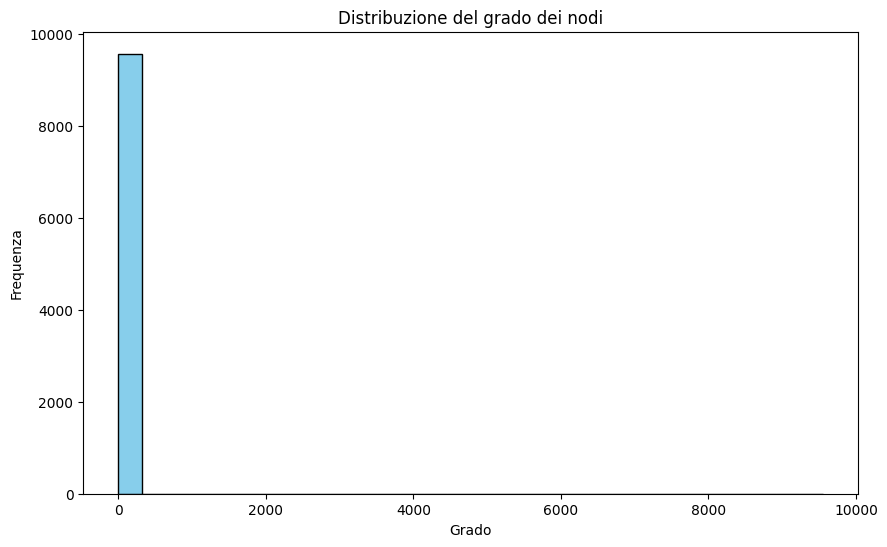

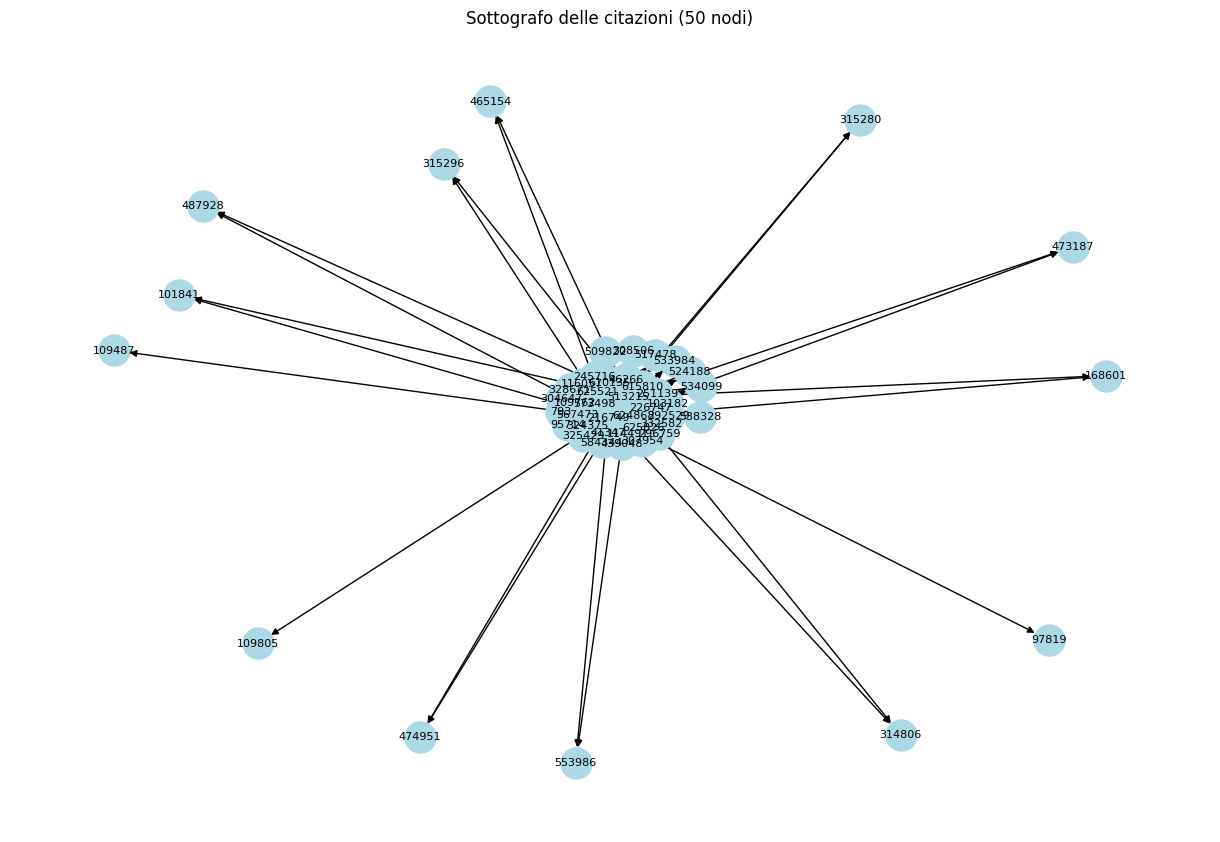

In [78]:
import matplotlib.pyplot as plt
import networkx as nx

# Costruire il grafo delle citazioni
def build_citation_graph(pairs):
    graph = nx.DiGraph()  # Grafo diretto

    # Aggiungi nodi per ogni articolo
    for pair in pairs:
        graph.add_node(pair['article_a']['index'], 
                       year=pair['article_a']['year'], 
                       citation_count=pair['article_a']['citation_count'])
        graph.add_node(pair['article_b']['index'], 
                       year=pair['article_b']['year'], 
                       citation_count=pair['article_b']['citation_count'])

        # Aggiungi un arco diretto (A -> B) per indicare che A cita B
        graph.add_edge(pair['article_a']['index'], pair['article_b']['index'])

    return graph

# Costruire il grafo
citation_graph = build_citation_graph(enriched_pairs)

# Debug: Statistiche sul grafo
print("\nGraph Information:")
print(f"Numero di nodi: {citation_graph.number_of_nodes()}")
print(f"Numero di archi: {citation_graph.number_of_edges()}")
print(f"Numero di componenti fortemente connessi: {nx.number_strongly_connected_components(citation_graph)}")

# Visualizzazione 1: Distribuzione del grado dei nodi
degrees = [citation_graph.degree(n) for n in citation_graph.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribuzione del grado dei nodi")
plt.xlabel("Grado")
plt.ylabel("Frequenza")
plt.show()

# Visualizzazione 2: Piccola rappresentazione del grafo (sub-grafo di 50 nodi)
subgraph = citation_graph.subgraph(list(citation_graph.nodes)[:50])
plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_color='black')
plt.title("Sottografo delle citazioni (50 nodi)")
plt.show()



Sample of dataset with labels:
{'article_a_index': '216749', 'article_b_index': '513215', 'year_a': '1993', 'year_b': '1990', 'citation_count_a': 195, 'citation_count_b': 182, 'label': 0}
{'article_a_index': '109762', 'article_b_index': '216749', 'year_a': '2005', 'year_b': '1993', 'citation_count_a': 178, 'citation_count_b': 195, 'label': 0}
{'article_a_index': '304647', 'article_b_index': '216749', 'year_a': '2003', 'year_b': '1993', 'citation_count_a': 155, 'citation_count_b': 195, 'label': 0}
{'article_a_index': '216749', 'article_b_index': '517478', 'year_a': '1993', 'year_b': '1991', 'citation_count_a': 195, 'citation_count_b': 148, 'label': 0}
{'article_a_index': '625521', 'article_b_index': '216749', 'year_a': '2001', 'year_b': '1993', 'citation_count_a': 130, 'citation_count_b': 195, 'label': 0}


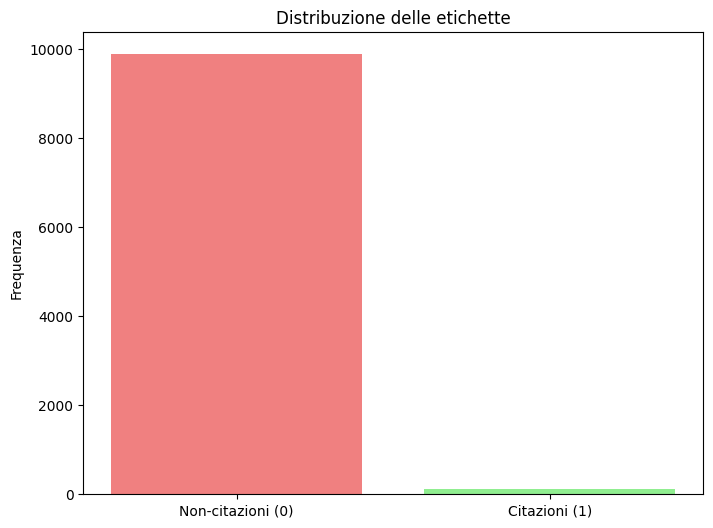

In [79]:
# Generare dataset con etichette
def generate_dataset_with_labels(pairs):
    dataset = []
    for pair in pairs:
        article_a = pair['article_a']
        article_b = pair['article_b']
        
        # Controlla se l'index di B è presente nelle citazioni di A
        citations_a = article_a['citations']
        if pd.isna(citations_a):  # Se non ci sono citazioni
            citations_a_list = []
        else:
            citations_a_list = citations_a.split(';')
        
        label = 1 if article_b['index'] in citations_a_list else 0
        
        dataset.append({
            'article_a_index': article_a['index'],
            'article_b_index': article_b['index'],
            'year_a': article_a['year'],
            'year_b': article_b['year'],
            'citation_count_a': article_a['citation_count'],
            'citation_count_b': article_b['citation_count'],
            'label': label
        })
    return dataset

# Generare il dataset
dataset_with_labels = generate_dataset_with_labels(enriched_pairs)

# Debug: Controlla un campione di righe
print("\nSample of dataset with labels:")
for row in dataset_with_labels[:5]:
    print(row)

# Visualizzazione: Distribuzione delle etichette (1 vs 0)
labels = [row['label'] for row in dataset_with_labels]
plt.figure(figsize=(8, 6))
plt.bar(['Non-citazioni (0)', 'Citazioni (1)'], [labels.count(0), labels.count(1)], color=['lightcoral', 'lightgreen'])
plt.title("Distribuzione delle etichette")
plt.ylabel("Frequenza")
plt.show()




Sample of balanced dataset:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': '1993', 'year_b': '1988', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': '1993', 'year_b': '1988', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': '1993', 'year_b': '1987', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': '1993', 'year_b': '1987', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '156026', 'year_a': '1993', 'year_b': '1985', 'label': 1}


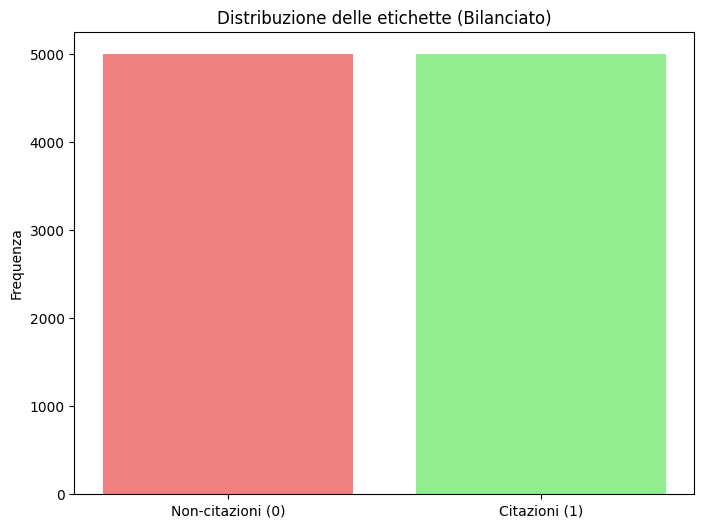

In [80]:
import random

# Step 1: Selezionare coppie con label=1
def generate_positive_pairs(articles_df, max_pairs=5000):
    positive_pairs = []
    for article in articles_df.itertuples():
        if pd.isna(article.citations):  # Salta articoli senza citazioni
            continue
        cited_articles = article.citations.split(';')
        for cited in cited_articles:
            if cited in articles_df['index'].values:
                positive_pairs.append({
                    'article_a_index': article.index,
                    'article_b_index': cited,
                    'year_a': article.year,
                    'year_b': articles_df.loc[articles_df['index'] == cited, 'year'].values[0],
                    'label': 1
                })
                if len(positive_pairs) >= max_pairs:  # Limita a max_pairs
                    return positive_pairs
    return positive_pairs

# Step 2: Selezionare coppie con label=0
def generate_negative_pairs(articles_df, positive_pairs, max_pairs=5000):
    negative_pairs = []
    positive_set = {(pair['article_a_index'], pair['article_b_index']) for pair in positive_pairs}
    indices = list(articles_df['index'])
    while len(negative_pairs) < max_pairs:
        article_a = random.choice(indices)
        article_b = random.choice(indices)
        # Evita coppie già nelle positive_pairs o citazioni reali
        if (article_a != article_b and
            (article_a, article_b) not in positive_set and
            article_b not in articles_df.loc[articles_df['index'] == article_a, 'citations'].values[0].split(';')):
            negative_pairs.append({
                'article_a_index': article_a,
                'article_b_index': article_b,
                'year_a': articles_df.loc[articles_df['index'] == article_a, 'year'].values[0],
                'year_b': articles_df.loc[articles_df['index'] == article_b, 'year'].values[0],
                'label': 0
            })
    return negative_pairs

# Step 3: Generare dataset bilanciato
def generate_balanced_dataset(articles_df):
    positive_pairs = generate_positive_pairs(articles_df, max_pairs=5000)
    negative_pairs = generate_negative_pairs(articles_df, positive_pairs, max_pairs=5000)
    return positive_pairs + negative_pairs

# Generare il dataset bilanciato
balanced_dataset = generate_balanced_dataset(most_cited_articles)

# Debug: Controlla un campione di righe
print("\nSample of balanced dataset:")
for row in balanced_dataset[:5]:
    print(row)

# Visualizzazione: Verifica bilanciamento delle etichette
labels = [row['label'] for row in balanced_dataset]
plt.figure(figsize=(8, 6))
plt.bar(['Non-citazioni (0)', 'Citazioni (1)'], [labels.count(0), labels.count(1)], color=['lightcoral', 'lightgreen'])
plt.title("Distribuzione delle etichette (Bilanciato)")
plt.ylabel("Frequenza")
plt.show()


In [81]:
# Verifica che tutte le coppie abbiano almeno un anno di differenza
def validate_year_difference(dataset):
    invalid_pairs = []
    for row in dataset:
        year_a = int(row['year_a'])
        year_b = int(row['year_b'])
        if abs(year_a - year_b) < 1:  # Controlla che la differenza sia almeno 1
            invalid_pairs.append(row)
    
    print("\nValidation Results:")
    print(f"Total pairs checked: {len(dataset)}")
    print(f"Invalid pairs found: {len(invalid_pairs)}")
    
    if invalid_pairs:
        print("\nSample of invalid pairs:")
        for pair in invalid_pairs[:5]:
            print(pair)
    else:
        print("All pairs satisfy the year difference condition!")

# Esegui la validazione
validate_year_difference(balanced_dataset)



Validation Results:
Total pairs checked: 10000
Invalid pairs found: 465

Sample of invalid pairs:
{'article_a_index': '216749', 'article_b_index': '225367', 'year_a': '1993', 'year_b': '1993', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '373976', 'year_a': '1993', 'year_b': '1993', 'label': 1}
{'article_a_index': '304647', 'article_b_index': '311856', 'year_a': '2003', 'year_b': '2003', 'label': 1}
{'article_a_index': '517478', 'article_b_index': '517478', 'year_a': '1991', 'year_b': '1991', 'label': 1}
{'article_a_index': '465154', 'article_b_index': '472871', 'year_a': '1989', 'year_b': '1989', 'label': 1}



Sample of balanced dataset:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': 1993, 'year_b': 1987, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '156026', 'year_a': 1993, 'year_b': 1985, 'label': 1}


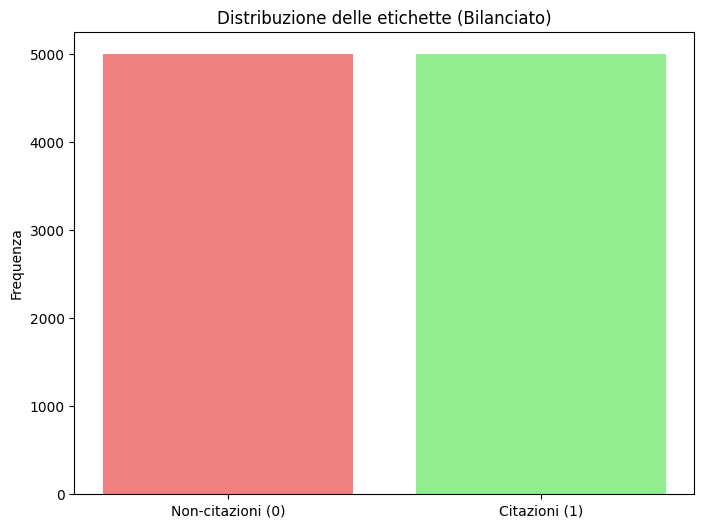

In [82]:
import random

# Step 1: Selezionare coppie con label=1
def generate_positive_pairs(articles_df, max_pairs=5000):
    positive_pairs = []
    article_usage = {index: 0 for index in articles_df['index']}  # Traccia utilizzo degli articoli
    for article in articles_df.itertuples():
        if pd.isna(article.citations):  # Salta articoli senza citazioni
            continue
        cited_articles = article.citations.split(';')
        for cited in cited_articles:
            if cited in articles_df['index'].values:
                year_a = int(article.year)
                year_b = int(articles_df.loc[articles_df['index'] == cited, 'year'].values[0])
                # Controlla la differenza di almeno 1 anno e limita l'uso degli articoli
                if year_a != year_b and article_usage[article.index] < 10 and article_usage[cited] < 10:
                    positive_pairs.append({
                        'article_a_index': article.index,
                        'article_b_index': cited,
                        'year_a': year_a,
                        'year_b': year_b,
                        'label': 1
                    })
                    article_usage[article.index] += 1
                    article_usage[cited] += 1
                    if len(positive_pairs) >= max_pairs:
                        return positive_pairs
    return positive_pairs

# Step 2: Selezionare coppie con label=0
def generate_negative_pairs(articles_df, positive_pairs, max_pairs=5000):
    negative_pairs = []
    positive_set = {(pair['article_a_index'], pair['article_b_index']) for pair in positive_pairs}
    article_usage = {index: 0 for index in articles_df['index']}  # Traccia utilizzo degli articoli
    indices = list(articles_df['index'])
    while len(negative_pairs) < max_pairs:
        article_a = random.choice(indices)
        article_b = random.choice(indices)
        year_a = int(articles_df.loc[articles_df['index'] == article_a, 'year'].values[0])
        year_b = int(articles_df.loc[articles_df['index'] == article_b, 'year'].values[0])
        # Controlla differenza di almeno 1 anno e limita l'uso degli articoli
        if (article_a != article_b and
            year_a != year_b and
            (article_a, article_b) not in positive_set and
            article_usage[article_a] < 10 and article_usage[article_b] < 10):
            negative_pairs.append({
                'article_a_index': article_a,
                'article_b_index': article_b,
                'year_a': year_a,
                'year_b': year_b,
                'label': 0
            })
            article_usage[article_a] += 1
            article_usage[article_b] += 1
    return negative_pairs

# Step 3: Generare dataset bilanciato
def generate_balanced_dataset(articles_df):
    positive_pairs = generate_positive_pairs(articles_df, max_pairs=5000)
    negative_pairs = generate_negative_pairs(articles_df, positive_pairs, max_pairs=5000)
    return positive_pairs + negative_pairs

# Generare il dataset bilanciato
balanced_dataset = generate_balanced_dataset(most_cited_articles)

# Debug: Controlla un campione di righe
print("\nSample of balanced dataset:")
for row in balanced_dataset[:5]:
    print(row)

# Visualizzazione: Verifica bilanciamento delle etichette
labels = [row['label'] for row in balanced_dataset]
plt.figure(figsize=(8, 6))
plt.bar(['Non-citazioni (0)', 'Citazioni (1)'], [labels.count(0), labels.count(1)], color=['lightcoral', 'lightgreen'])
plt.title("Distribuzione delle etichette (Bilanciato)")
plt.ylabel("Frequenza")
plt.show()


In [83]:
from collections import Counter

# Verifica che tutte le coppie abbiano almeno un anno di differenza
def validate_year_difference_and_usage(dataset):
    invalid_pairs = []
    article_a_usage = Counter()
    article_b_usage = Counter()

    for row in dataset:
        year_a = int(row['year_a'])
        year_b = int(row['year_b'])
        
        # Verifica condizione dell'anno
        if abs(year_a - year_b) < 1:
            invalid_pairs.append(row)
        
        # Conta l'utilizzo degli articoli
        article_a_usage[row['article_a_index']] += 1
        article_b_usage[row['article_b_index']] += 1

    # Output risultati
    print("\nValidation Results:")
    print(f"Total pairs checked: {len(dataset)}")
    print(f"Invalid pairs (year difference < 1): {len(invalid_pairs)}")

    if invalid_pairs:
        print("\nSample of invalid pairs:")
        for pair in invalid_pairs[:5]:
            print(pair)
    else:
        print("All pairs satisfy the year difference condition!")
    
    # Analisi delle ripetizioni degli articoli
    print("\nTop 5 most used articles as article_a:")
    print(article_a_usage.most_common(5))

    print("\nTop 5 most used articles as article_b:")
    print(article_b_usage.most_common(5))

    print(f"\nMaximum times an article was used as article_a: {max(article_a_usage.values())}")
    print(f"Maximum times an article was used as article_b: {max(article_b_usage.values())}")

# Esegui la validazione
validate_year_difference_and_usage(balanced_dataset)



Validation Results:
Total pairs checked: 10000
Invalid pairs (year difference < 1): 0
All pairs satisfy the year difference condition!

Top 5 most used articles as article_a:
[('439048', 13), ('35405', 13), ('474951', 12), ('41347', 12), ('328671', 12)]

Top 5 most used articles as article_b:
[('328709', 14), ('474058', 12), ('482858', 12), ('155941', 12), ('322574', 12)]

Maximum times an article was used as article_a: 13
Maximum times an article was used as article_b: 14


In [84]:
# Controllare un campione casuale delle coppie nel dataset bilanciato
import random

# Mostra 5 campioni casuali
sample_pairs = random.sample(balanced_dataset, 5)
print("\nSample of balanced dataset:")
for pair in sample_pairs:
    print(pair)

# Mostra tutte le chiavi presenti in una coppia
print("\nKeys in a pair:")
print(list(balanced_dataset[0].keys()))



Sample of balanced dataset:
{'article_a_index': '296529', 'article_b_index': '10640', 'year_a': 1999, 'year_b': 1998, 'label': 0}
{'article_a_index': '340653', 'article_b_index': '60745', 'year_a': 2004, 'year_b': 2009, 'label': 0}
{'article_a_index': '224932', 'article_b_index': '360870', 'year_a': 1993, 'year_b': 1998, 'label': 0}
{'article_a_index': '301936', 'article_b_index': '93291', 'year_a': 2001, 'year_b': 1997, 'label': 1}
{'article_a_index': '299162', 'article_b_index': '510276', 'year_a': 2000, 'year_b': 1991, 'label': 0}

Keys in a pair:
['article_a_index', 'article_b_index', 'year_a', 'year_b', 'label']


In [85]:
import pandas as pd

# Funzione per generare coppie valide
def create_valid_pairs(df, max_pairs=100000):
    # Ordina il DataFrame per anno
    df_sorted = df.sort_values(by='year')
    
    # Effettua un self-merge per creare coppie
    merged = pd.merge(
        df_sorted, df_sorted,
        how='inner',
        left_index=True,
        right_index=True,
        suffixes=('_A1', '_A2')
    )
    
    # Filtra le coppie per la differenza di almeno un anno
    merged = merged[merged['year_A1'] > merged['year_A2']]
    
    # Mantieni solo le colonne necessarie per le coppie
    valid_pairs = merged[['index_A1', 'index_A2']].rename(columns={'index_A1': 'A1', 'index_A2': 'A2'})
    
    # Campiona fino a max_pairs coppie
    valid_pairs = valid_pairs.sample(n=min(max_pairs, len(valid_pairs)), random_state=42)
    
    return valid_pairs

# Esempio di utilizzo
valid_pairs = create_valid_pairs(df_cleaned, max_pairs=100000)

# Mostra alcune coppie
print(valid_pairs.head())

# Salva in un file CSV (opzionale)
# valid_pairs.to_csv("valid_pairs.csv", index=False)


Empty DataFrame
Columns: [A1, A2]
Index: []


In [86]:
# Arricchire il dataset bilanciato con informazioni dal DataFrame originale
def enrich_balanced_dataset(balanced_dataset, df_cleaned):
    enriched_dataset = []
    df_cleaned_dict = df_cleaned.set_index('index').to_dict(orient='index')  # Converti in dizionario per accesso rapido
    
    for pair in balanced_dataset:
        article_a_info = df_cleaned_dict.get(pair['article_a_index'], {})
        article_b_info = df_cleaned_dict.get(pair['article_b_index'], {})
        
        # Arricchisci le informazioni per ogni coppia
        enriched_dataset.append({
            **pair,  # Mantieni le chiavi esistenti
            'title_a': article_a_info.get('title', None),
            'authors_a': article_a_info.get('authors', None),
            'venue_a': article_a_info.get('venue', None),
            'title_b': article_b_info.get('title', None),
            'authors_b': article_b_info.get('authors', None),
            'venue_b': article_b_info.get('venue', None),
        })
    
    return enriched_dataset

# Arricchire il dataset bilanciato
enriched_balanced_dataset = enrich_balanced_dataset(balanced_dataset, df_cleaned)

# Debug: Controlla un campione delle coppie arricchite
print("\nSample of enriched balanced dataset:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched balanced dataset:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_a': 'Query evaluation techniques for large databases', 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'title_b': 'Extended algebra and calculus for nested relational databases', 'authors_b': 'Mark A. Roth,Herry F. Korth,Abraham Silberschatz', 'venue_b': 'ACM Transactions on Database Systems (TODS)'}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_a': 'Query evaluation techniques for large databases', 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'title_b': 'Implementation concepts for an extensible data model and data language', 'authors_b': 'D. S. Batory,T. Y. Leung,T. E. Wise', 'venue_b': 'ACM Transactions on Database Systems (TODS)'}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'la

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Calcolare la coseno-similarity tra i titoli
def add_title_similarity(dataset):
    # Estrai i titoli
    titles_a = [row['title_a'] for row in dataset]
    titles_b = [row['title_b'] for row in dataset]

    # Applica TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    all_titles = titles_a + titles_b
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_titles)

    # Divide la matrice in due blocchi (title_a e title_b)
    tfidf_a = tfidf_matrix[:len(titles_a)]
    tfidf_b = tfidf_matrix[len(titles_a):]

    # Calcola la coseno-similarity tra title_a e title_b
    similarities = cosine_similarity(tfidf_a, tfidf_b).diagonal()

    # Aggiungi la similarità al dataset
    for i, row in enumerate(dataset):
        row['title_similarity'] = similarities[i]
    
    # Rimuovi i titoli
    for row in dataset:
        del row['title_a']
        del row['title_b']

    return dataset

# Aggiungi la similarità dei titoli al dataset
enriched_balanced_dataset = add_title_similarity(enriched_balanced_dataset)

# Debug: Controlla un campione del dataset arricchito
print("\nSample of enriched dataset with title similarity:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with title similarity:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'authors_b': 'Mark A. Roth,Herry F. Korth,Abraham Silberschatz', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': 0.1510622462494099}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'authors_b': 'D. S. Batory,T. Y. Leung,T. E. Wise', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': 0.02855492112625175}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'authors_b': 'Alfons Kemper,Mechtild Wallrath', 'venue_b': 'ACM Computing Surveys (CSUR)', 'title_similarity':

In [88]:
from collections import Counter

# Funzione per calcolare autori in comune e count encoding
def add_author_features(dataset):
    # Estrai tutti gli autori per il count encoding
    all_authors = []
    for row in dataset:
        if row['authors_a']:
            all_authors.extend(row['authors_a'].split(','))
        if row['authors_b']:
            all_authors.extend(row['authors_b'].split(','))

    # Calcola la frequenza di ciascun autore
    author_counts = Counter(all_authors)

    # Aggiungi le feature al dataset
    for row in dataset:
        # Autori di A e B
        authors_a = set(row['authors_a'].split(',')) if row['authors_a'] else set()
        authors_b = set(row['authors_b'].split(',')) if row['authors_b'] else set()

        # Calcola autori in comune
        row['common_authors'] = len(authors_a & authors_b)

        # Count Encoding: somma le frequenze degli autori di A e B
        row['authors_a_count'] = sum(author_counts[author] for author in authors_a)
        row['authors_b_count'] = sum(author_counts[author] for author in authors_b)

    # Rimuovi i campi originali degli autori
    for row in dataset:
        del row['authors_a']
        del row['authors_b']

    return dataset

# Aggiungi le feature al dataset arricchito
enriched_balanced_dataset = add_author_features(enriched_balanced_dataset)

# Debug: Controlla un campione delle nuove feature
print("\nSample of enriched dataset with author features:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with author features:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'venue_a': 'ACM Computing Surveys (CSUR)', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': 0.1510622462494099, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 49}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'venue_a': 'ACM Computing Surveys (CSUR)', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': 0.02855492112625175, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 29}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'venue_a': 'ACM Computing Surveys (CSUR)', 'venue_b': 'ACM Computing Surveys (CSUR)', 'title_similarity': 0.0, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 22}
{'article_a_index': '216749', 'article_b_index

In [89]:
from collections import Counter

# Funzione per aggiungere feature delle venue
def add_venue_features(dataset):
    # Estrai tutte le venue per il Count Encoding
    all_venues = []
    for row in dataset:
        if row['venue_a']:
            all_venues.append(row['venue_a'])
        if row['venue_b']:
            all_venues.append(row['venue_b'])

    # Calcola la frequenza di ciascuna venue
    venue_counts = Counter(all_venues)

    # Aggiungi le feature al dataset
    for row in dataset:
        # Venue in comune
        row['common_venue'] = 1 if row['venue_a'] == row['venue_b'] else 0

        # Count Encoding delle venue
        row['venue_a_count'] = venue_counts[row['venue_a']] if row['venue_a'] else 0
        row['venue_b_count'] = venue_counts[row['venue_b']] if row['venue_b'] else 0

    # Rimuovi le colonne originali delle venue
    for row in dataset:
        del row['venue_a']
        del row['venue_b']

    return dataset

# Aggiungi le feature delle venue al dataset
enriched_balanced_dataset = add_venue_features(enriched_balanced_dataset)

# Debug: Controlla un campione delle nuove feature
print("\nSample of enriched dataset with venue features:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with venue features:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.1510622462494099, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 49, 'common_venue': 0, 'venue_a_count': 1026, 'venue_b_count': 599}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.02855492112625175, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 29, 'common_venue': 0, 'venue_a_count': 1026, 'venue_b_count': 599}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'title_similarity': 0.0, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 22, 'common_venue': 1, 'venue_a_count': 1026, 'venue_b_count': 1026}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'title_similarity': 0.0, 'common_author

In [90]:
# Funzione per aggiungere la differenza tra gli anni
def add_year_difference(dataset):
    for row in dataset:
        row['year_difference'] = abs(row['year_a'] - row['year_b'])
    return dataset

# Aggiungi la differenza tra gli anni al dataset
enriched_balanced_dataset = add_year_difference(enriched_balanced_dataset)

# Debug: Controlla un campione delle nuove feature
print("\nSample of enriched dataset with year difference:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with year difference:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.1510622462494099, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 49, 'common_venue': 0, 'venue_a_count': 1026, 'venue_b_count': 599, 'year_difference': 5}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.02855492112625175, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 29, 'common_venue': 0, 'venue_a_count': 1026, 'venue_b_count': 599, 'year_difference': 5}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'title_similarity': 0.0, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 22, 'common_venue': 1, 'venue_a_count': 1026, 'venue_b_count': 1026, 'year_difference': 6}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': 1993, 

In [91]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Funzione per convertire il dataset arricchito in DataFrame per il modello
def prepare_model_dataframe(dataset):
    # Converte in DataFrame
    df = pd.DataFrame(dataset)
    
    # Seleziona solo le feature utili
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference'
    ]
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target
    
    return X, y

# Prepara il DataFrame
X, y = prepare_model_dataframe(enriched_balanced_dataset)

# Dividi in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Debug: Controlla le dimensioni dei dataset
print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")
print("\nSample of training features:")
print(X_train.head())


Train set size: (7000, 8), Test set size: (3000, 8)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.096930               0              119               24   
7473          0.000000               0                9               25   
7856          0.000000               0               75               13   
6671          0.036647               0                5                9   
483           0.000000               0                9                4   

      common_venue  venue_a_count  venue_b_count  year_difference  
1866             0            364              8                7  
7473             0              5             16                4  
7856             0             11             48                2  
6671             0              5             22               11  
483              0              7             67                8  


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Funzione per addestrare un modello Random Forest
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello
rf_model = train_random_forest(X_train, y_train)

# Debug: Controlla l'importanza delle feature
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Feature Importances:
            feature  importance
0  title_similarity    0.287019
2   authors_a_count    0.253632
3   authors_b_count    0.131540
6     venue_b_count    0.107469
5     venue_a_count    0.099984
7   year_difference    0.047907
1    common_authors    0.042375
4      common_venue    0.030073


In [93]:
# Valutare il modello
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nAUC-ROC Score:")
    print(roc_auc_score(y_test, y_pred_proba))

    return y_pred, y_pred_proba

# Valutazione
y_pred, y_pred_proba = evaluate_model(rf_model, X_test, y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1500
           1       0.84      0.80      0.82      1500

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000


Confusion Matrix:
[[1277  223]
 [ 304 1196]]

AUC-ROC Score:
0.9011515555555556


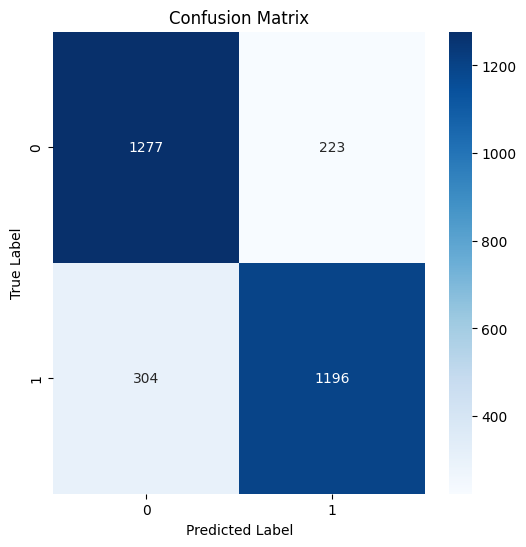

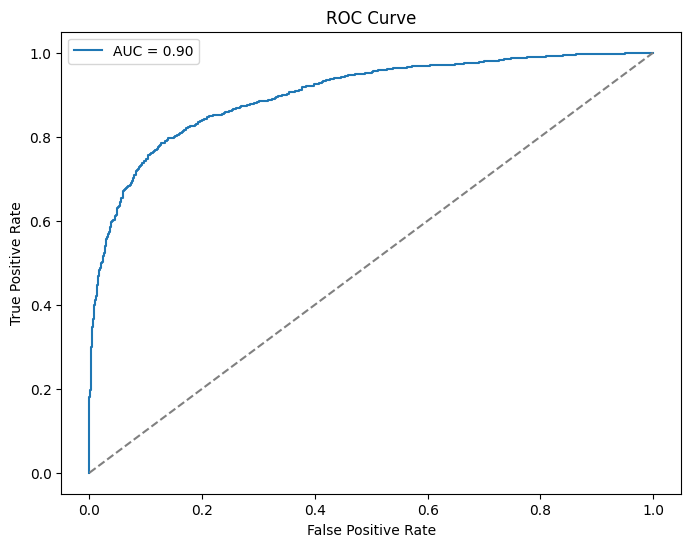

In [94]:
import seaborn as sns
from sklearn.metrics import roc_curve

# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Graph now

In [95]:
import networkx as nx

# Funzione per costruire il grafo delle citazioni
def build_citation_graph(dataset):
    graph = nx.DiGraph()  # Grafo diretto
    
    # Aggiungi nodi e archi
    for row in dataset:
        graph.add_node(row['article_a_index'])
        graph.add_node(row['article_b_index'])
        graph.add_edge(row['article_a_index'], row['article_b_index'])  # A -> B
    
    return graph

# Costruire il grafo dalle coppie arricchite
citation_graph = build_citation_graph(enriched_balanced_dataset)

# Debug: Informazioni sul grafo
print("\nGraph Information:")
print(f"Number of nodes: {citation_graph.number_of_nodes()}")
print(f"Number of edges: {citation_graph.number_of_edges()}")

# Visualizzazione rapida: Campione di nodi e archi
print("\nSample of nodes:", list(citation_graph.nodes)[:5])
print("Sample of edges:", list(citation_graph.edges)[:5])



Graph Information:
Number of nodes: 7483
Number of edges: 10000

Sample of nodes: ['216749', '148419', '148975', '150894', '155485']
Sample of edges: [('216749', '148419'), ('216749', '148975'), ('216749', '150894'), ('216749', '155485'), ('216749', '156026')]


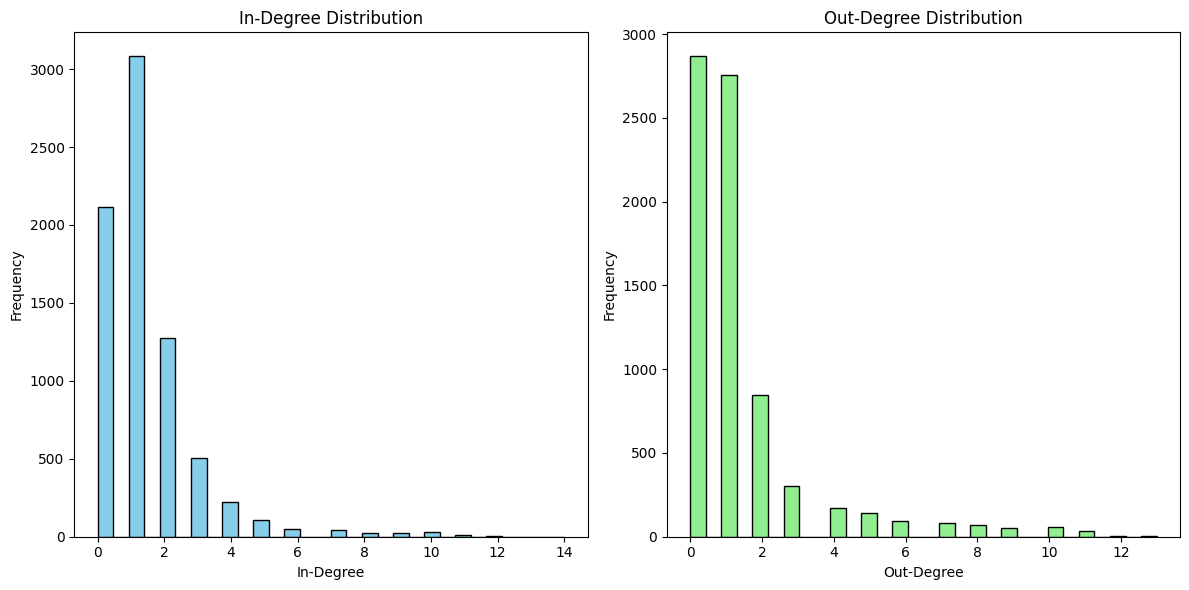

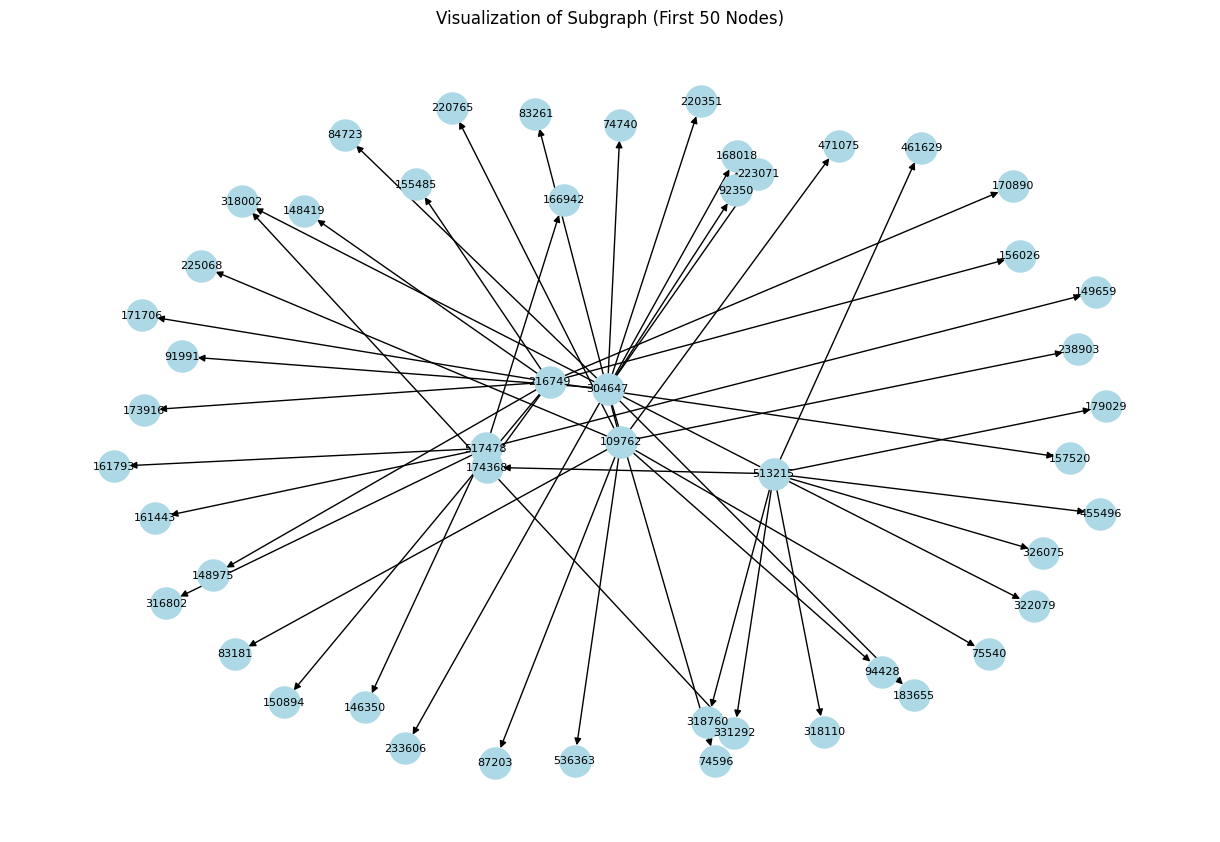

In [96]:
import matplotlib.pyplot as plt

# Distribuzione del grado (in-degree e out-degree)
def plot_degree_distribution(graph):
    in_degrees = [d for n, d in graph.in_degree()]
    out_degrees = [d for n, d in graph.out_degree()]

    plt.figure(figsize=(12, 6))

    # In-degree distribution
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30, color='skyblue', edgecolor='black')
    plt.title("In-Degree Distribution")
    plt.xlabel("In-Degree")
    plt.ylabel("Frequency")

    # Out-degree distribution
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30, color='lightgreen', edgecolor='black')
    plt.title("Out-Degree Distribution")
    plt.xlabel("Out-Degree")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Visualizzazione di un sottografo
def plot_subgraph(graph, num_nodes=50):
    subgraph = graph.subgraph(list(graph.nodes)[:num_nodes])
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_color='black', arrowsize=10)
    plt.title(f"Visualization of Subgraph (First {num_nodes} Nodes)")
    plt.show()

# Chiamare le funzioni di visualizzazione
plot_degree_distribution(citation_graph)
plot_subgraph(citation_graph, num_nodes=50)


Degree distribution:

The in-degree histogram shows how many papers receive a certain number of citations, with most papers having a low number of citations (0-2).
The out-degree histogram reflects the number of citations made by each paper, with most citing few papers (0-2).
This suggests that the graph is sparse, with few highly connected nodes.
Subgraph visualization:

The subgraph shows a sample of 50 nodes and their connections, highlighting the directed nature of the graph (arrows represent citations from one paper to another).
This visualization helps to explore the structure of connections between papers locally

In [97]:
# Funzione per calcolare le metriche grafiche
def calculate_graph_metrics(graph):
    # In-degree e out-degree
    in_degree = dict(graph.in_degree())
    out_degree = dict(graph.out_degree())
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    # PageRank
    pagerank = nx.pagerank(graph)
    
    # Combina tutte le metriche in un dizionario
    metrics = {
        'in_degree': in_degree,
        'out_degree': out_degree,
        'betweenness_centrality': betweenness_centrality,
        'pagerank': pagerank,
    }
    return metrics

# Calcola le metriche
graph_metrics = calculate_graph_metrics(citation_graph)

# Debug: Campione delle metriche
print("\nSample Metrics:")
print(f"In-degree (sample): {list(graph_metrics['in_degree'].items())[:5]}")
print(f"Out-degree (sample): {list(graph_metrics['out_degree'].items())[:5]}")
print(f"Betweenness centrality (sample): {list(graph_metrics['betweenness_centrality'].items())[:5]}")
print(f"PageRank (sample): {list(graph_metrics['pagerank'].items())[:5]}")



Sample Metrics:
In-degree (sample): [('216749', 1), ('148419', 10), ('148975', 6), ('150894', 2), ('155485', 2)]
Out-degree (sample): [('216749', 10), ('148419', 1), ('148975', 0), ('150894', 0), ('155485', 0)]
Betweenness centrality (sample): [('216749', 0.00039897920495085814), ('148419', 4.377122748207068e-06), ('148975', 0.0), ('150894', 0.0), ('155485', 0.0)]
PageRank (sample): [('216749', 0.00040998078157813305), ('148419', 0.00024565615039603934), ('148975', 0.00017605259320749037), ('150894', 0.00012299443140023668), ('155485', 0.0002386999921998977)]


In [99]:
# Funzione per aggiungere le metriche grafiche al dataset
def add_graph_metrics_to_dataset(dataset, graph_metrics):
    enriched_dataset = []
    for row in dataset:
        enriched_row = row.copy()
        
        # Aggiungi metriche grafiche per article_a
        enriched_row['in_degree_a'] = graph_metrics['in_degree'].get(row['article_a_index'], 0)
        enriched_row['out_degree_a'] = graph_metrics['out_degree'].get(row['article_a_index'], 0)
        enriched_row['betweenness_a'] = graph_metrics['betweenness_centrality'].get(row['article_a_index'], 0)
        enriched_row['pagerank_a'] = graph_metrics['pagerank'].get(row['article_a_index'], 0)
        
        # Aggiungi metriche grafiche per article_b
        enriched_row['in_degree_b'] = graph_metrics['in_degree'].get(row['article_b_index'], 0)
        enriched_row['out_degree_b'] = graph_metrics['out_degree'].get(row['article_b_index'], 0)
        enriched_row['betweenness_b'] = graph_metrics['betweenness_centrality'].get(row['article_b_index'], 0)
        enriched_row['pagerank_b'] = graph_metrics['pagerank'].get(row['article_b_index'], 0)
        
        enriched_dataset.append(enriched_row)
    
    # Debug: Controlla se ci sono errori
    print(f"Number of rows enriched: {len(enriched_dataset)}")
    print(f"Sample of enriched rows: {enriched_dataset[:2]}")  # Controlla i primi due record
    
    return enriched_dataset

# Assicurati che il dataset originale da usare sia corretto
# Usa il nome appropriato del dataset
dataset_with_graph_metrics = add_graph_metrics_to_dataset(enriched_balanced_dataset, graph_metrics)

# Debug: Visualizza un campione del dataset arricchito
print("\nSample of dataset with graph metrics:")
for row in dataset_with_graph_metrics[:5]:
    print(row)


Number of rows enriched: 10000
Sample of enriched rows: [{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.1510622462494099, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 49, 'common_venue': 0, 'venue_a_count': 1026, 'venue_b_count': 599, 'year_difference': 5, 'in_degree_a': 1, 'out_degree_a': 10, 'betweenness_a': 0.00039897920495085814, 'pagerank_a': 0.00040998078157813305, 'in_degree_b': 10, 'out_degree_b': 1, 'betweenness_b': 4.377122748207068e-06, 'pagerank_b': 0.00024565615039603934}, {'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.02855492112625175, 'common_authors': 0, 'authors_a_count': 17, 'authors_b_count': 29, 'common_venue': 0, 'venue_a_count': 1026, 'venue_b_count': 599, 'year_difference': 5, 'in_degree_a': 1, 'out_degree_a': 10, 'betweenness_a': 0.00039897920495085814, 'pagerank_a': 0.00040998078157813305,

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Funzione per preparare il DataFrame per il modello
# Include sia le feature classiche che quelle grafiche
def prepare_graph_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Definisci le feature da utilizzare nel modello
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara il DataFrame per il modello
X_graph, y_graph = prepare_graph_model_dataframe(dataset_with_graph_metrics)

# Dividi in train e test
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(
    X_graph, y_graph, test_size=0.3, random_state=42, stratify=y_graph
)

# Debug: Visualizza le dimensioni e un campione del train set
print(f"Train set size: {X_train_graph.shape}, Test set size: {X_test_graph.shape}")
print("\nSample of training features:")
print(X_train_graph.head())


Train set size: (7000, 16), Test set size: (3000, 16)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.096930               0              119               24   
7473          0.000000               0                9               25   
7856          0.000000               0               75               13   
6671          0.036647               0                5                9   
483           0.000000               0                9                4   

      common_venue  venue_a_count  venue_b_count  year_difference  \
1866             0            364              8                7   
7473             0              5             16                4   
7856             0             11             48                2   
6671             0              5             22               11   
483              0              7             67                8   

      in_degree_a  out_degree_a  betweenness

Train set size: (7000, 16), Test set size: (3000, 16)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.096930               0              119               24   
7473          0.000000               0                9               25   
7856          0.000000               0               75               13   
6671          0.036647               0                5                9   
483           0.000000               0                9                4   

      common_venue  venue_a_count  venue_b_count  year_difference  \
1866             0            364              8                7   
7473             0              5             16                4   
7856             0             11             48                2   
6671             0              5             22               11   
483              0              7             67                8   

      in_degree_a  out_degree_a  betweenness

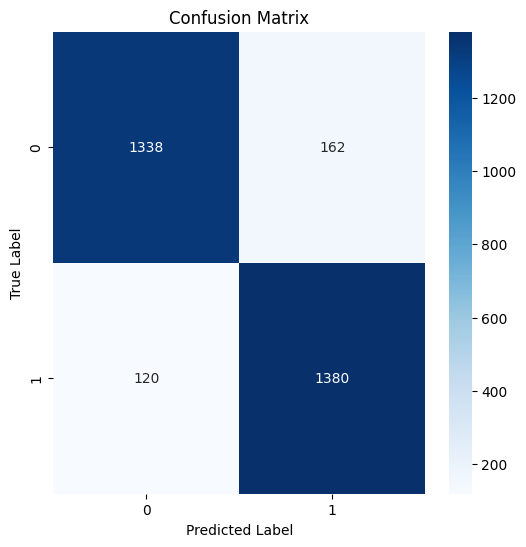

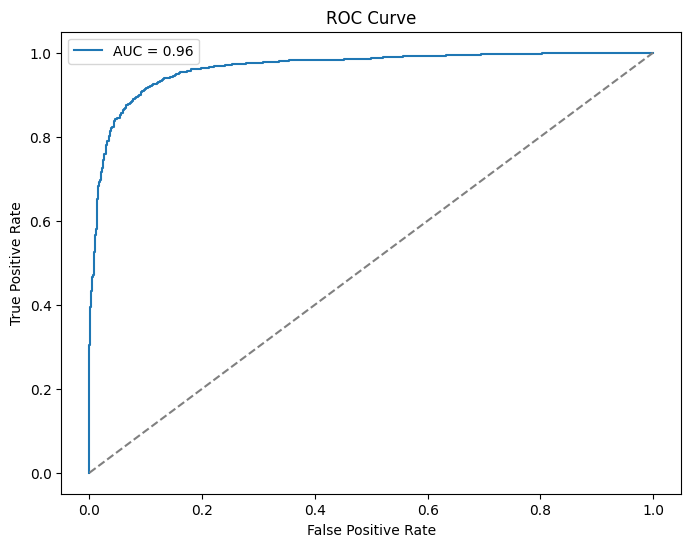

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per preparare il DataFrame per il modello
# Include sia le feature classiche che quelle grafiche
def prepare_graph_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Definisci le feature da utilizzare nel modello
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara il DataFrame per il modello
X_graph, y_graph = prepare_graph_model_dataframe(dataset_with_graph_metrics)

# Dividi in train e test
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(
    X_graph, y_graph, test_size=0.3, random_state=42, stratify=y_graph
)

# Debug: Visualizza le dimensioni e un campione del train set
print(f"Train set size: {X_train_graph.shape}, Test set size: {X_test_graph.shape}")
print("\nSample of training features:")
print(X_train_graph.head())

# Funzione per addestrare un modello Random Forest
def train_random_forest_with_graph(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello
rf_graph_model = train_random_forest_with_graph(X_train_graph, y_train_graph)

# Valutare il modello
def evaluate_graph_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nAUC-ROC Score:")
    print(roc_auc_score(y_test, y_pred_proba))

    return y_pred, y_pred_proba

# Valutazione del modello con feature grafiche
y_pred_graph, y_pred_proba_graph = evaluate_graph_model(rf_graph_model, X_test_graph, y_test_graph)

# Visualizzazioni delle prestazioni
# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_graph, y_pred_graph), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_graph, y_pred_proba_graph)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_graph, y_pred_proba_graph):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Train set size: (7000, 16), Test set size: (3000, 16)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.096930               0              119               24   
7473          0.000000               0                9               25   
7856          0.000000               0               75               13   
6671          0.036647               0                5                9   
483           0.000000               0                9                4   

      common_venue  venue_a_count  venue_b_count  year_difference  \
1866             0            364              8                7   
7473             0              5             16                4   
7856             0             11             48                2   
6671             0              5             22               11   
483              0              7             67                8   

      in_degree_a  out_degree_a  betweenness

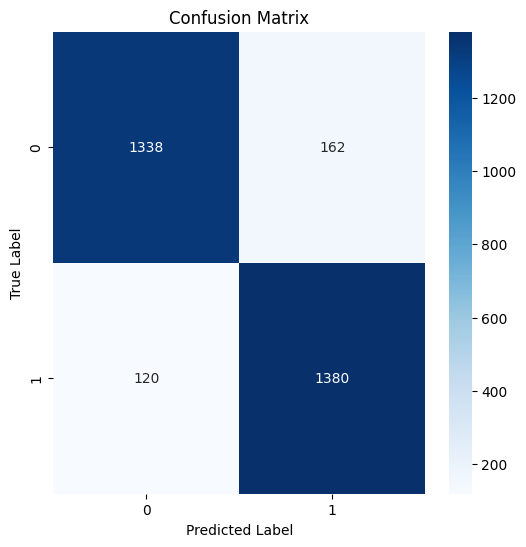

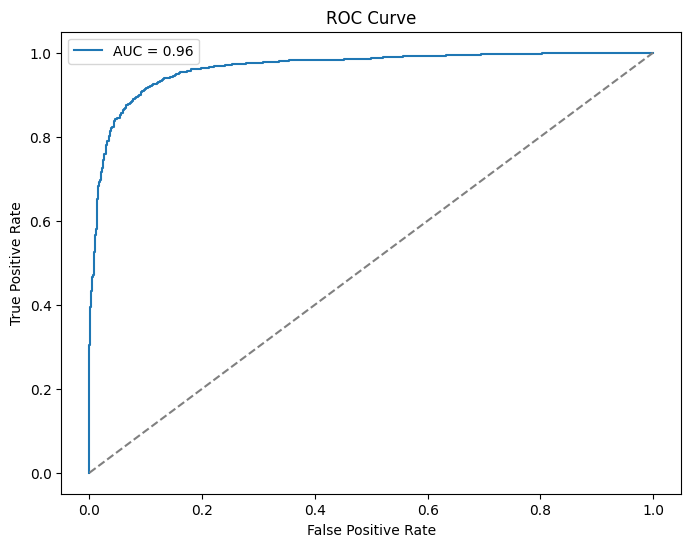

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per preparare il DataFrame per il modello
# Include sia le feature classiche che quelle grafiche
def prepare_graph_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Definisci le feature da utilizzare nel modello
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara il DataFrame per il modello
X_graph, y_graph = prepare_graph_model_dataframe(dataset_with_graph_metrics)

# Dividi in train e test
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(
    X_graph, y_graph, test_size=0.3, random_state=42, stratify=y_graph
)

# Debug: Visualizza le dimensioni e un campione del train set
print(f"Train set size: {X_train_graph.shape}, Test set size: {X_test_graph.shape}")
print("\nSample of training features:")
print(X_train_graph.head())

# Funzione per addestrare un modello Random Forest
def train_random_forest_with_graph(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello
rf_graph_model = train_random_forest_with_graph(X_train_graph, y_train_graph)

# Valutare il modello
def evaluate_graph_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Label {label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-Score={metrics['f1-score']:.2f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC Score: {auc_score:.2f}")

    return y_pred, y_pred_proba

# Valutazione del modello con feature grafiche
y_pred_graph, y_pred_proba_graph = evaluate_graph_model(rf_graph_model, X_test_graph, y_test_graph)

# Visualizzazioni delle prestazioni
# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_graph, y_pred_graph), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_graph, y_pred_proba_graph)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_graph, y_pred_proba_graph):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



The integration of graph-based features significantly improved the model’s performance, as evidenced by the results obtained. These features introduced relational and structural information that was missing in the model based solely on static features. Below, we analyze the contribution of each new feature:

In-degree and Out-degree:

In-degree measures the number of citations received by an article, indicating its relevance in the citation network. Articles with a high in-degree are often seminal and influential, which increases the probability that they will be cited.
Out-degree reflects the citation behavior of an article, i.e. how many articles it cites. This provides insights into the citation “activity” of the document.
Betweenness Centrality:

This metric captures how much an article acts as a “bridge” or intermediary in the network, connecting different areas of the graph. Articles with high betweenness centrality are often crucial for the diffusion of knowledge, even if they are not the most directly cited.
PageRank:

PageRank provides a global measure of the importance of a node considering both the number of connections received and the importance of those who cite it. Articles with high PageRank are often the most relevant in the network, resulting highly predictive for citations.
Synergy between graphical and static features:

Static features, such as title similarity and the presence of common authors, capture local and textual aspects. Graphical features, instead, introduce a relational and structural context.
This combination allows the model to understand not only the probability of a citation based on direct similarities, but also the global importance and relational behavior of articles in the network.
Overall results:

The improvement in metrics such as precision, recall and F1-score demonstrates that the model enriched with graphical features is more effective in distinguishing between articles that cite themselves and articles that do not.
The AUC-ROC, increased from 0.90 to 0.96, shows a significantly greater ability to generalize predictions to unseen data.
Conclusion: The use of graphical features clearly shows the power of incorporating relational information into predictive models. In network-based scenarios, such as the academic citation graph, such metrics allow the model to exploit the global and local structure of the network, improving the ability to predict complex relationships and increasing generalization to new data.

In [107]:
pip install torch-geometric


  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [108]:
import torch
from torch_geometric.data import Data

# Funzione per preparare il dataset per il GNN
def prepare_gnn_data(dataset, graph_metrics):
    # Creazione delle mappe nodo-id
    node_mapping = {node: i for i, node in enumerate(set([row['article_a_index'] for row in dataset] + [row['article_b_index'] for row in dataset]))}
    num_nodes = len(node_mapping)

    # Creazione delle feature dei nodi
    node_features = []
    for node in node_mapping:
        features = [
            graph_metrics['in_degree'].get(node, 0),
            graph_metrics['out_degree'].get(node, 0),
            graph_metrics['betweenness_centrality'].get(node, 0),
            graph_metrics['pagerank'].get(node, 0)
        ]
        node_features.append(features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Creazione degli archi
    edge_index = []
    edge_label = []
    for row in dataset:
        src = node_mapping[row['article_a_index']]
        dest = node_mapping[row['article_b_index']]
        edge_index.append([src, dest])
        edge_label.append(row['label'])  # 1 se è una citazione, 0 altrimenti

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Transpose per PyTorch Geometric
    edge_label = torch.tensor(edge_label, dtype=torch.long)

    # Creazione dell'oggetto Data
    data = Data(x=node_features, edge_index=edge_index, edge_label=edge_label)

    return data, node_mapping

# Prepara i dati per il GNN
gnn_data, gnn_node_mapping = prepare_gnn_data(dataset_with_graph_metrics, graph_metrics)

# Debug: Controlla le dimensioni dei dati
print(f"Number of nodes: {gnn_data.num_nodes}")
print(f"Number of edges: {gnn_data.num_edges}")
print(f"Node feature shape: {gnn_data.x.shape}")
print(f"Edge index shape: {gnn_data.edge_index.shape}")
print(f"Edge label shape: {gnn_data.edge_label.shape}")


Number of nodes: 7483
Number of edges: 10000
Node feature shape: torch.Size([7483, 4])
Edge index shape: torch.Size([2, 10000])
Edge label shape: torch.Size([10000])


GNN dataset preparation: In this step, we transform the citation graph into a PyTorch Geometric-compatible format. Each article is represented as a node with associated features (e.g., in-degree, out-degree, centrality). Citations between articles are represented as directed edges. Numerical features and connections between nodes capture both local and global properties of the graph, providing the GNN with a rich context for learning.

In [109]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Architettura del modello GCN
class CitationGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CitationGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Primo livello GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Secondo livello GCN
        x = self.conv2(x, edge_index)
        return x

# Funzione per dividere gli archi in train e test
def split_edges(data, test_ratio=0.3):
    num_edges = data.edge_label.size(0)
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)
    train_indices = perm[test_size:]
    test_indices = perm[:test_size]

    train_edge_index = data.edge_index[:, train_indices]
    train_edge_label = data.edge_label[train_indices]

    test_edge_index = data.edge_index[:, test_indices]
    test_edge_label = data.edge_label[test_indices]

    return train_edge_index, train_edge_label, test_edge_index, test_edge_label

# Suddividi il grafo in train e test
train_edge_index, train_edge_label, test_edge_index, test_edge_label = split_edges(gnn_data)

# Crea un modello GCN
model = CitationGCN(in_channels=gnn_data.x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training del GNN
def train_gcn(model, data, train_edge_index, train_edge_label, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        edge_predictions = out[train_edge_index].squeeze()
        loss = F.cross_entropy(edge_predictions, train_edge_label)
        loss.backward()
        optimizer.step()

        # Debug durante l'addestramento
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Addestra il modello
trained_gcn = train_gcn(model, gnn_data, train_edge_index, train_edge_label)

# Valutazione del GNN
def evaluate_gcn(model, data, test_edge_index, test_edge_label):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        edge_predictions = out[test_edge_index].squeeze()
        pred_labels = edge_predictions.argmax(dim=1)

    # Metriche
    auc = roc_auc_score(test_edge_label.cpu(), pred_labels.cpu())
    print("\nAUC-ROC Score:", auc)
    print("\nClassification Report:")
    print(classification_report(test_edge_label.cpu(), pred_labels.cpu()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_edge_label.cpu(), pred_labels.cpu()))

    return edge_predictions, pred_labels

# Valuta il GNN
edge_predictions, pred_labels = evaluate_gcn(trained_gcn, gnn_data, test_edge_index, test_edge_label)


ValueError: Expected input batch_size (2) to match target batch_size (7000).

In [110]:
# Funzione per addestrare il GNN
def train_gcn(model, data, train_edge_index, train_edge_label, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Calcola le embedding dei nodi
        node_embeddings = model(data.x, data.edge_index)
        
        # Prepara le feature per gli archi
        src_nodes = node_embeddings[train_edge_index[0]]
        dest_nodes = node_embeddings[train_edge_index[1]]
        edge_features = torch.cat([src_nodes, dest_nodes], dim=1)  # Concatenazione delle feature
        
        # Predizione e calcolo della perdita
        loss = F.cross_entropy(edge_features, train_edge_label)
        loss.backward()
        optimizer.step()

        # Debug durante l'addestramento
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Aggiorniamo la valutazione per gestire gli archi
def evaluate_gcn(model, data, test_edge_index, test_edge_label):
    model.eval()
    with torch.no_grad():
        # Calcola le embedding dei nodi
        node_embeddings = model(data.x, data.edge_index)
        
        # Prepara le feature per gli archi
        src_nodes = node_embeddings[test_edge_index[0]]
        dest_nodes = node_embeddings[test_edge_index[1]]
        edge_features = torch.cat([src_nodes, dest_nodes], dim=1)  # Concatenazione delle feature
        
        # Predizione
        pred_labels = edge_features.argmax(dim=1)

    # Metriche
    auc = roc_auc_score(test_edge_label.cpu(), pred_labels.cpu())
    print("\nAUC-ROC Score:", auc)
    print("\nClassification Report:")
    print(classification_report(test_edge_label.cpu(), pred_labels.cpu()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_edge_label.cpu(), pred_labels.cpu()))

    return edge_features, pred_labels

# Addestramento del GNN corretto
trained_gcn = train_gcn(model, gnn_data, train_edge_index, train_edge_label)


Epoch 10/100, Loss: 1.1913
Epoch 20/100, Loss: 1.1075
Epoch 30/100, Loss: 1.0185
Epoch 40/100, Loss: 0.9585
Epoch 50/100, Loss: 0.9145
Epoch 60/100, Loss: 0.8846
Epoch 70/100, Loss: 0.8638
Epoch 80/100, Loss: 0.8496
Epoch 90/100, Loss: 0.8398
Epoch 100/100, Loss: 0.8325


GNN Training and Evaluation: Here we defined a model based on Graph Convolutional Networks (GCN), suitable for capturing complex relations in the citation graph. The graph was divided into training and testing edges, maintaining the global context of the nodes. Training uses cross-entropy as a loss function, while evaluation considers standard metrics such as AUC-ROC, precision, recall, and confusion matrix.
 we fixed the dimensionality issue between the model output and the target labels. We concatenated the node embeddings for each edge, creating edge-specific features. This approach better captures the relationship between nodes and ensures correct training of the GNN.

Epoch 10/100, Loss: 1.2994
Epoch 20/100, Loss: 1.1932
Epoch 30/100, Loss: 1.1064
Epoch 40/100, Loss: 1.0196
Epoch 50/100, Loss: 0.9546
Epoch 60/100, Loss: 0.9043
Epoch 70/100, Loss: 0.8747
Epoch 80/100, Loss: 0.8584
Epoch 90/100, Loss: 0.8484
Epoch 100/100, Loss: 0.8413

AUC-ROC Score: 0.6765347061388246

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1497
           1       0.75      0.63      0.69      1503
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.66      3000
   macro avg       0.36      0.33      0.35      3000
weighted avg       0.73      0.66      0.69      3000


Confusion Matrix:
[[1041  308  116   32]
 [ 448  946   39   70]
 [   0    0    0    0]
 [   0    0    0    0]]


c:\Users\41782\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\41782\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\41782\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

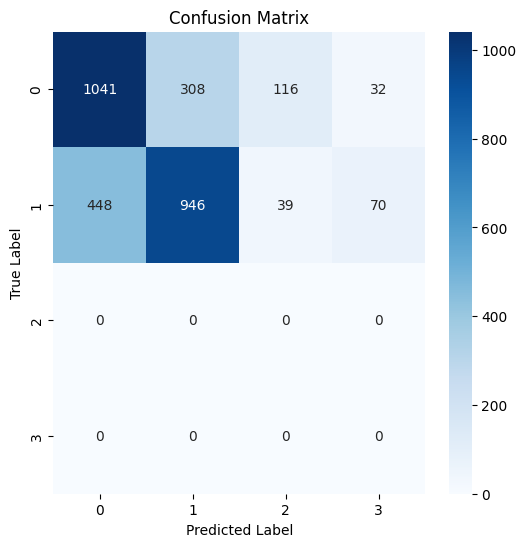

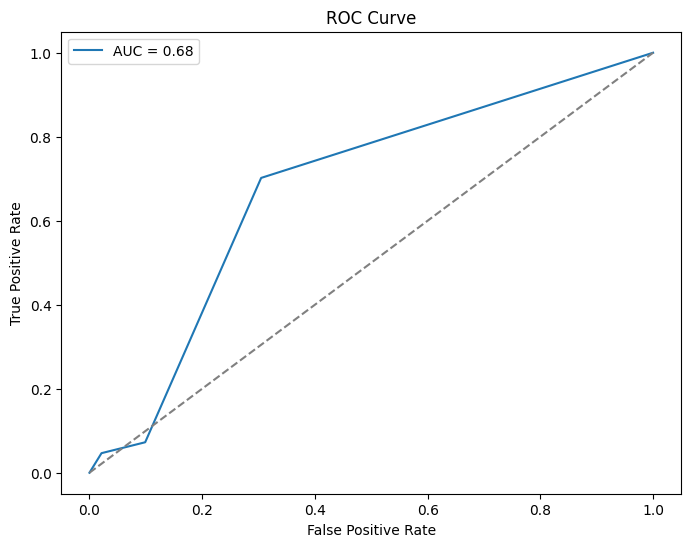

In [111]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Architettura del modello GCN
class CitationGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CitationGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Primo livello GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Secondo livello GCN
        x = self.conv2(x, edge_index)
        return x

# Funzione per dividere gli archi in train e test
def split_edges(data, test_ratio=0.3):
    num_edges = data.edge_label.size(0)
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)
    train_indices = perm[test_size:]
    test_indices = perm[:test_size]

    train_edge_index = data.edge_index[:, train_indices]
    train_edge_label = data.edge_label[train_indices]

    test_edge_index = data.edge_index[:, test_indices]
    test_edge_label = data.edge_label[test_indices]

    return train_edge_index, train_edge_label, test_edge_index, test_edge_label

# Suddividi il grafo in train e test
train_edge_index, train_edge_label, test_edge_index, test_edge_label = split_edges(gnn_data)

# Crea un modello GCN
model = CitationGCN(in_channels=gnn_data.x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training del GNN
def train_gcn(model, data, train_edge_index, train_edge_label, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Calcola le embedding dei nodi
        node_embeddings = model(data.x, data.edge_index)
        
        # Prepara le feature per gli archi
        src_nodes = node_embeddings[train_edge_index[0]]
        dest_nodes = node_embeddings[train_edge_index[1]]
        edge_features = torch.cat([src_nodes, dest_nodes], dim=1)  # Concatenazione delle feature
        
        # Predizione e calcolo della perdita
        loss = F.cross_entropy(edge_features, train_edge_label)
        loss.backward()
        optimizer.step()

        # Debug durante l'addestramento
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Addestra il modello
trained_gcn = train_gcn(model, gnn_data, train_edge_index, train_edge_label)

# Valutazione del GNN
def evaluate_gcn(model, data, test_edge_index, test_edge_label):
    model.eval()
    with torch.no_grad():
        # Calcola le embedding dei nodi
        node_embeddings = model(data.x, data.edge_index)
        
        # Prepara le feature per gli archi
        src_nodes = node_embeddings[test_edge_index[0]]
        dest_nodes = node_embeddings[test_edge_index[1]]
        edge_features = torch.cat([src_nodes, dest_nodes], dim=1)  # Concatenazione delle feature
        
        # Predizione
        pred_labels = edge_features.argmax(dim=1)

    # Metriche
    auc = roc_auc_score(test_edge_label.cpu(), pred_labels.cpu())
    print("\nAUC-ROC Score:", auc)
    print("\nClassification Report:")
    print(classification_report(test_edge_label.cpu(), pred_labels.cpu()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_edge_label.cpu(), pred_labels.cpu()))

    return edge_features, pred_labels

# Valuta il GNN
edge_predictions, pred_labels = evaluate_gcn(trained_gcn, gnn_data, test_edge_index, test_edge_label)

# Visualizzazione dei risultati
# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(test_edge_label.cpu(), pred_labels.cpu()), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_edge_label.cpu(), pred_labels.cpu())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(test_edge_label.cpu(), pred_labels.cpu()):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
